# Monarch Take Home Assignment

October 2025

In [1]:
import pandas as pd
import sqlite3 as sql 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from scipy.stats import t, norm, ttest_ind_from_stats

### DB Set up

In [2]:
conn = sql.connect("/Users/clairemeyer/Documents/monarch_takehome.db")

In [3]:
test_query = """
    SELECT treatment, 
        COUNT(DISTINCT t.anonymous_id), 
        COUNT(u.user_id)
    FROM experiment_assisgnment t 
    LEFT JOIN user_events u 
        ON t.ANONYMOUS_ID = u.ANONYMOUS_ID
    GROUP BY 1;
"""

df = pd.read_sql_query(test_query,conn)
df.head()

,TREATMENT,COUNT(DISTINCT t.anonymous_id),COUNT(u.user_id)
0,ca,311866,6958
1,va,312680,7006


### Exploratory Analysis

##### LTV

SQLite does not have a median or percentile functionality, so we use Python to quickly review the distribution here.

In [4]:
ltv_query = '''

SELECT * FROM user_level_deduped
WHERE ltv is not null;
'''
ltv_df = pd.read_sql_query(ltv_query,conn)

# standardize column names to lowercase
ltv_df.columns = ltv_df.columns.str.lower()
# LTV numeric
ltv_df['ltv'] = pd.to_numeric(ltv_df['ltv'], errors='coerce')

print(ltv_df.columns)

Index(['user_id', 'treatment', 'client_platform', 'ft_converted',
       'sub_converted', 'refunded', 'ltv', 'initial_billing_period',
       'has_promo_code', 'had_cs_ticket_during_trial',
       'monarch_attribution_source', 'user_reported_attribution',
       'canceled_during_trial', 'count_days_active_in_first_7_days_of_trial',
       'count_events_in_first_7_days_of_trial',
       'count_events_in_first_1_day_of_trial'],
      dtype='object')


In [5]:
# Summary by treatment variant
summary_treatment = (
    ltv_df.groupby(['treatment'])
      .agg(
          mean_ltv=('ltv', 'mean'),
          median_ltv=('ltv', 'median'),
          p95_ltv=('ltv', lambda x: x.quantile(0.95)),
          count=('ltv', 'count')
      )
      .reset_index()
)

print(summary_treatment)

  treatment    mean_ltv  median_ltv  p95_ltv  count
0        ca  129.836527       130.0    159.0   4227
1        va  129.248369       130.0    159.0   4139


In [6]:
# Summary by treatment variant and client platform
summary_treatment_platform = (
    ltv_df.groupby(['treatment', 'client_platform'])
      .agg(
          mean_ltv=('ltv', 'mean'),
          median_ltv=('ltv', 'median'),
          p95_ltv=('ltv', lambda x: x.quantile(0.95)),
          count=('ltv', 'count')
      )
      .reset_index()
)

print(summary_treatment_platform)

  treatment client_platform    mean_ltv  median_ltv  p95_ltv  count
0        ca      mobile_web  125.078652       110.0    159.0    801
1        ca             web  130.948920       130.0    159.0   3426
2        va      mobile_web  125.073897       110.0    159.0    839
3        va             web  130.309697       130.0    159.0   3300


In [7]:
# Summary by client platform
summary_platform = (
    ltv_df.groupby(['client_platform'])
      .agg(
          mean_ltv=('ltv', 'mean'),
          median_ltv=('ltv', 'median'),
          p95_ltv=('ltv', lambda x: x.quantile(0.95)),
          count=('ltv', 'count')
      )
      .reset_index()
)

print(summary_platform)

  client_platform    mean_ltv  median_ltv  p95_ltv  count
0      mobile_web  125.076220       110.0    159.0   1640
1             web  130.635296       130.0    159.0   6726


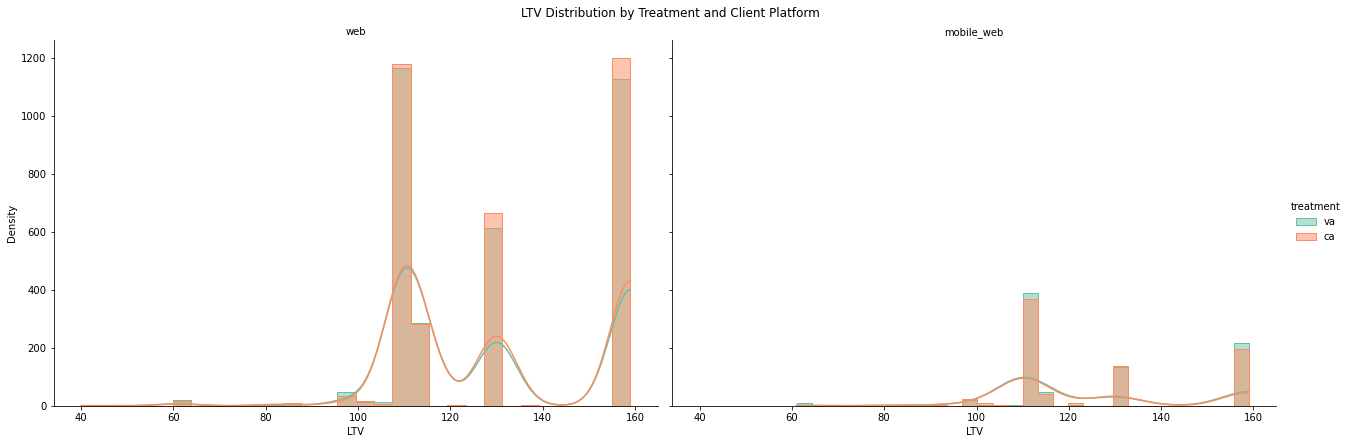

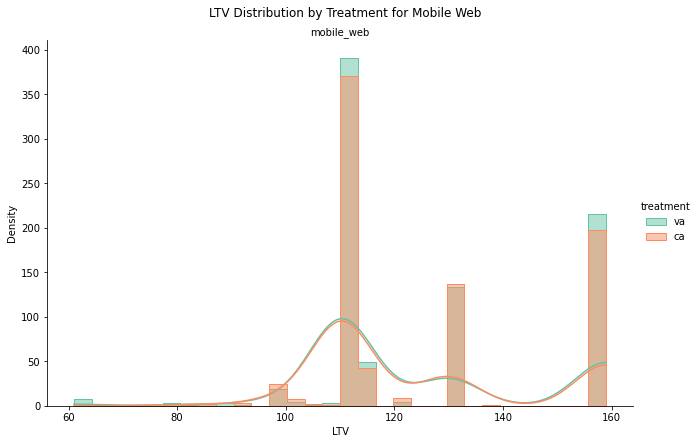

In [8]:
# Facet distribtuions by client platform and treatment

g = sns.FacetGrid(
    ltv_df,
    col="client_platform",
    hue="treatment",
    height=6,
    aspect=1.5,
    palette="Set2"
)

# Map the histplot to the FacetGrid
g.map(
    sns.histplot,
    "ltv",
    kde=True,
    bins=30,
    common_norm=False,
    element="step"
)

g.set_axis_labels("LTV", "Density")
g.set_titles(col_template="{col_name}")
g.fig.suptitle("LTV Distribution by Treatment and Client Platform", y=1.02)
g.add_legend()
# Filter the data to only include "mobile_web" for better readability
mobile_web_data = ltv_df[ltv_df["client_platform"] == "mobile_web"]

# Update the FacetGrid to use only the filtered data
g = sns.FacetGrid(
    mobile_web_data,
    col="client_platform",
    hue="treatment",
    height=6,
    aspect=1.5,
    palette="Set2"
)

# Map the histplot to the FacetGrid
g.map(
    sns.histplot,
    "ltv",
    kde=True,
    bins=30,
    common_norm=False,
    element="step"
)

g.set_axis_labels("LTV", "Density")
g.set_titles(col_template="{col_name}")
g.fig.suptitle("LTV Distribution by Treatment for Mobile Web", y=1.02)
g.add_legend()
plt.show()

##### Billing Period

We recreate the same summary statistics by Billing Period, to understand interplay with this field and LTV. 

In [9]:

ltv_billing_query = '''
SELECT
    initial_billing_period,
    ltv
FROM user_properties; '''

ltv_billing_df = pd.read_sql_query(ltv_billing_query,conn)
# standardize column names to lowercase
ltv_billing_df.columns = ltv_billing_df.columns.str.lower()
# LTV numeric
ltv_billing_df['ltv'] = pd.to_numeric(ltv_billing_df['ltv'], errors='coerce')

In [10]:
# Summary by billing period
summary_billing = (
    ltv_billing_df.groupby(['initial_billing_period'])
      .agg(
          mean_ltv=('ltv', 'mean'),
          median_ltv=('ltv', 'median'),
          p95_ltv=('ltv', lambda x: x.quantile(0.95)),
          count=('ltv', 'count')
      )
      .reset_index()
)

print(summary_billing)

  initial_billing_period    mean_ltv  median_ltv  p95_ltv  count
0                MONTHLY  110.269799       115.0    115.0    745
1              SPONSORED   86.000000        86.0     86.0      1
2                 YEARLY  131.391913       130.0    159.0   7716


In [11]:
# Summary by billing period, client platform
summary_billing_platform = (
        ltv_df.groupby(['client_platform', 'initial_billing_period'])
        .agg(mean_ltv=('ltv', 'mean'), count=('ltv', 'count'))
        .reset_index()
    )

print(summary_billing_platform)


  client_platform initial_billing_period    mean_ltv  count
0      mobile_web                MONTHLY  107.321429    112
1      mobile_web                 YEARLY  126.377618   1528
2             web                MONTHLY  110.744409    626
3             web              SPONSORED   86.000000      1
4             web                 YEARLY  132.684211   6099


#### Engagement Metrics & Correlation

To analyze engagement and create some correlation matrices between engagement and key conversion/LTV metrics, we grab user level activity.

In [12]:
user_query = '''
    SELECT u.*
    FROM user_level_deduped u
;
'''
user_df = pd.read_sql_query(user_query,conn)
# standardize column names to lowercase
user_df.columns = user_df.columns.str.lower()

# LTV numeric
user_df['ltv'] = pd.to_numeric(user_df['ltv'], errors='coerce')

user_df.head()
user_df.columns


Index(['user_id', 'treatment', 'client_platform', 'ft_converted',
       'sub_converted', 'refunded', 'ltv', 'initial_billing_period',
       'has_promo_code', 'had_cs_ticket_during_trial',
       'monarch_attribution_source', 'user_reported_attribution',
       'canceled_during_trial', 'count_days_active_in_first_7_days_of_trial',
       'count_events_in_first_7_days_of_trial',
       'count_events_in_first_1_day_of_trial'],
      dtype='object')

##### Summary of engagement metrics

In [ ]:
# Calculate mean and median for engagement fields by treatment and client platform
engagement_summary = (
    user_df.groupby(['treatment', 'client_platform'])
    .agg(
        count_days_active_in_first_7_days_of_trial_Median=('count_days_active_in_first_7_days_of_trial', 'median'),
        count_days_active_in_first_7_days_of_trial_Mean=('count_days_active_in_first_7_days_of_trial', 'mean'),
        count_events_in_first_7_days_of_trial_Median=('count_events_in_first_7_days_of_trial', 'median'),
        count_events_in_first_7_days_of_trial_Mean=('count_events_in_first_7_days_of_trial', 'mean'),
        count_events_in_first_1_day_of_trial_Median=('count_events_in_first_1_day_of_trial', 'median'),
        count_events_in_first_1_day_of_trial_Mean=('count_events_in_first_1_day_of_trial', 'mean')
    )
    .reset_index()
)

# Display the summary
print(engagement_summary)


  treatment client_platform  count_days_active_in_first_7_days_of_trial_Q1  \
0        ca      mobile_web                                            0.0   
1        ca             web                                            1.0   
2        va      mobile_web                                            1.0   
3        va             web                                            1.0   

   count_days_active_in_first_7_days_of_trial_Median  \
0                                                3.0   
1                                                3.0   
2                                                2.0   
3                                                3.0   

   count_days_active_in_first_7_days_of_trial_Mean  \
0                                         3.021888   
1                                         3.279057   
2                                         2.957059   
3                                         3.172047   

   count_days_active_in_first_7_days_of_trial_Q3  \
0    

##### Correlation Matrices


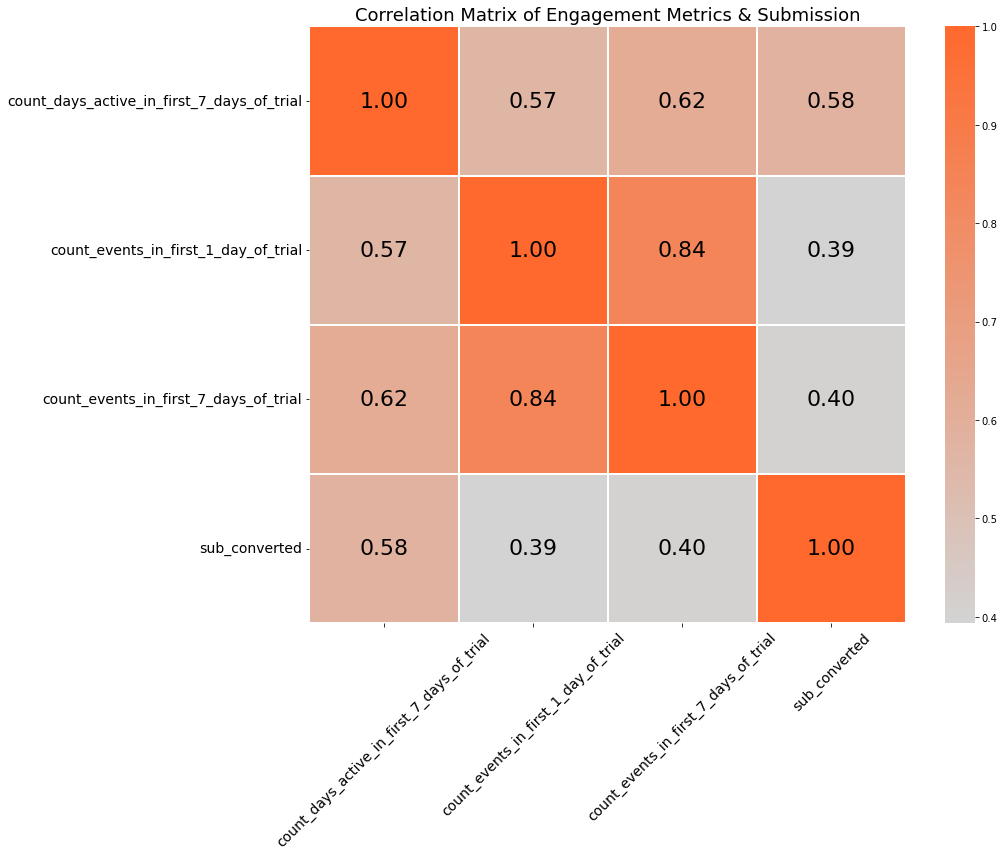

In [13]:
# Print Correlation Matrix with Subscription Conversion from Free Trial

# Fill missing values in 'ltv' with 0 for correlation analysis
user_df['ltv'] = user_df['ltv'].fillna(0)


# Compute the correlation matrix
corr_cols = [
    "count_days_active_in_first_7_days_of_trial",
    "count_events_in_first_1_day_of_trial",
    "count_events_in_first_7_days_of_trial",
    "sub_converted"
    #"ltv"
]
corr_matrix = user_df[corr_cols].corr()

# Create a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap=plt.cm.colors.LinearSegmentedColormap.from_list("", ["lightgrey", "#ff692d"]),
    cbar=True, 
    square=True, 
    linewidths=2, 
    annot_kws={"size": 22, "color": "black"}  # Set annotation text color to black
)
plt.title("Correlation Matrix of Engagement Metrics & Submission", fontsize=18)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Highlight highly correlated fields
#threshold = 0.7
#high_corr_pairs = corr_matrix[(corr_matrix.abs() > threshold) & (corr_matrix != 1.0)]
#print("Highly correlated fields (threshold > 0.7):")
#print(high_corr_pairs.dropna(how="all").dropna(axis=1, how="all"))

plt.show()

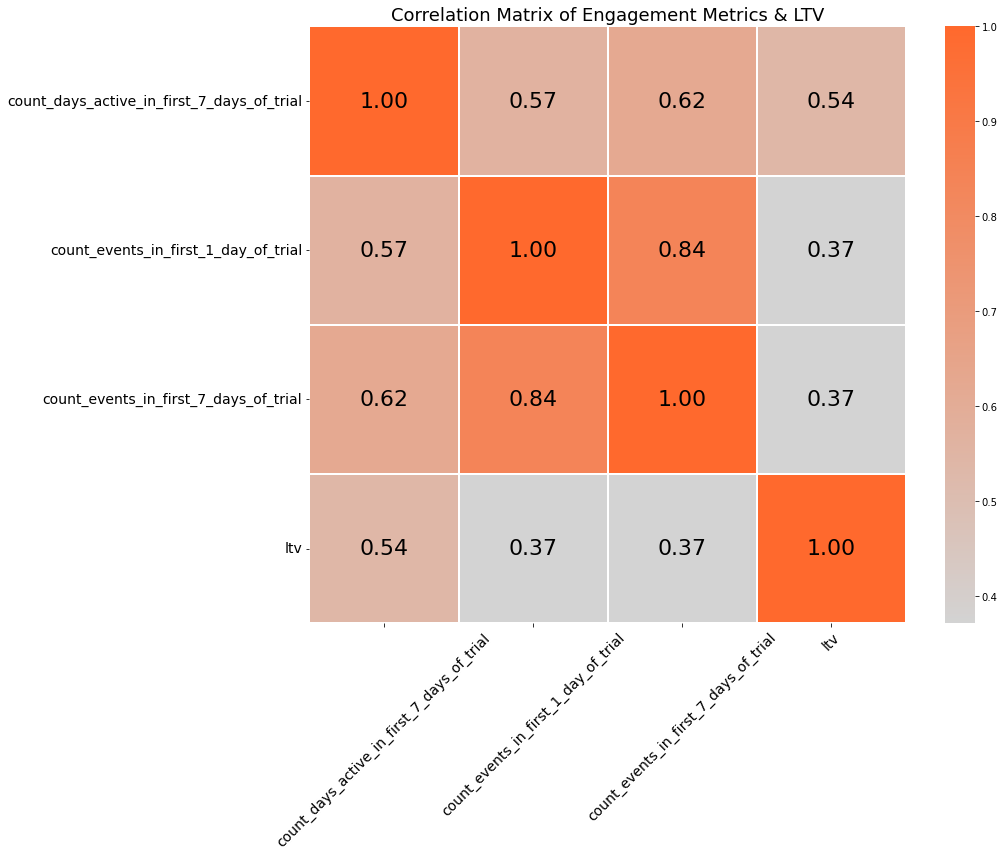

In [14]:
# Print Correlation Matrix with LTV


# Fill missing values in 'ltv' with 0 (or use another strategy like dropping rows with NaN)
user_df['ltv'] = user_df['ltv'].fillna(0)

# Compute the correlation matrix
corr_cols = [
    "count_days_active_in_first_7_days_of_trial",
    "count_events_in_first_1_day_of_trial",
    "count_events_in_first_7_days_of_trial",
    #"sub_converted"
    "ltv"
]
corr_matrix = user_df[corr_cols].corr()

# Create a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap=plt.cm.colors.LinearSegmentedColormap.from_list("", ["lightgrey", "#ff692d"]),
    cbar=True, 
    square=True, 
    linewidths=2, 
    annot_kws={"size": 22, "color": "black"}  # Set annotation text color to black
)
plt.title("Correlation Matrix of Engagement Metrics & LTV", fontsize=18)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Highlight highly correlated fields
#threshold = 0.7
#high_corr_pairs = corr_matrix[(corr_matrix.abs() > threshold) & (corr_matrix != 1.0)]
#print("Highly correlated fields (threshold > 0.7):")
#print(high_corr_pairs.dropna(how="all").dropna(axis=1, how="all"))

plt.show()

### Statistical Testing

Defining functions to test A/B metrics, depending on metric types.

In [15]:
ALPHA = 0.95
POWER = 0.8

COLS_TO_PRINT = [
    'Metric',
    'Control Mean',
    'Test Mean',
    'Delta',
    'Relative Delta',
    'Min. Detectable Effect',
    'p-value',
    '95% CI for Delta',
]


def welch_ttest(
    mu_ctrl: float,
    var_ctrl: float,
    n_ctrl: float,
    mu_test: float,
    var_test: float,
    n_test: float,
    alpha: float = ALPHA,
    power: float = POWER,
) -> List:
    if n_ctrl < 2 or n_test < 2 or (var_ctrl == 0 and var_test == 0):
        return [np.nan, np.nan, np.nan]

    deg = int(
        ((var_ctrl / n_ctrl + var_test / n_test) ** 2)
        / (
            ((var_ctrl / n_ctrl) ** 2 / (n_ctrl - 1))
            + ((var_test / n_test) ** 2 / (n_test - 1))
        )
    )
    critical_value = t.ppf(q=1 - ((1 - alpha) / 2), df=deg)
    critical_power = t.ppf(q=power, df=deg)

    diff = mu_test - mu_ctrl
    se_diff = np.sqrt(var_ctrl / n_ctrl + var_test / n_test)

    conf_lower = diff - se_diff * critical_value
    conf_upper = diff + se_diff * critical_value
    mde = se_diff * (critical_value + critical_power)

    return [conf_lower, conf_upper, mde]


def proportions_ztest(
    mu_ctrl: float,
    n_ctrl: float,
    mu_test: float,
    n_test: float,
    alpha: float = ALPHA,
    power: float = POWER,
) -> List:
    if n_ctrl < 2 or n_test < 2 or (mu_ctrl in (0, 1) and mu_test in (0, 1)):
        return [np.nan, np.nan, np.nan, np.nan]

    critical_value = norm.ppf(1 - ((1 - alpha) / 2))
    critical_power = norm.ppf(power)

    diff = mu_test - mu_ctrl
    se_diff = np.sqrt(
        (mu_ctrl * (1 - mu_ctrl)) / n_ctrl + (mu_test * (1 - mu_test)) / n_test
    )
    pval = 2 * (1 - norm.cdf(np.abs(diff / se_diff)))

    conf_lower = diff - se_diff * critical_value
    conf_upper = diff + se_diff * critical_value
    mde = se_diff * (critical_value + critical_power)

    return [pval, conf_lower, conf_upper, mde]

def pval(row):
    if row['METRIC_TYPE'] == 'BOOLEAN':
        p = proportions_ztest(
          mu_ctrl = row['AVG_METRIC_VALUE_CTRL'],
          n_ctrl = row['NUM_CUSTOMERS_CTRL'],
          mu_test = row['AVG_METRIC_VALUE_TEST'],
          n_test = row['NUM_CUSTOMERS_TEST'],
        )[0]
        return round(p, 4)

    elif row['METRIC_TYPE'] == 'CONTINUOUS':
        p = ttest_ind_from_stats(
          mean1=row['AVG_METRIC_VALUE_CTRL'],
          std1=row['STDDEV_METRIC_VALUE_CTRL'],
          nobs1=row['NUM_CUSTOMERS_CTRL'],
          mean2=row['AVG_METRIC_VALUE_TEST'],
          std2=row['STDDEV_METRIC_VALUE_TEST'],
          nobs2=row['NUM_CUSTOMERS_TEST'],
          equal_var=False,
          alternative='two-sided',
        ).pvalue
        return round(p, 4)

    elif row['METRIC_TYPE'] == 'RATIO':
        p = continuous_ztest(
          mu_ctrl = row['AVG_METRIC_VALUE_CTRL'],
          var_ctrl = row['STDDEV_METRIC_VALUE_CTRL'] ** 2,
          n_ctrl = row['NUM_CUSTOMERS_CTRL'],
          mu_test = row['AVG_METRIC_VALUE_TEST'],
          var_test = row['STDDEV_METRIC_VALUE_TEST'] ** 2,
          n_test = row['NUM_CUSTOMERS_TEST'],
        )[0]
        return round(p, 4)


def conf_int(row):
    if row['METRIC_TYPE'] == 'BOOLEAN':
        ci = proportions_ztest(
            mu_ctrl = row['AVG_METRIC_VALUE_CTRL'],
            n_ctrl = row['NUM_CUSTOMERS_CTRL'],
            mu_test = row['AVG_METRIC_VALUE_TEST'],
            n_test = row['NUM_CUSTOMERS_TEST'],
        )[1:3]
        return ['{:.2f}%'.format(i*100) for i in ci]

    elif row['METRIC_TYPE'] == 'CONTINUOUS':
        ci = welch_ttest(
            mu_ctrl = row['AVG_METRIC_VALUE_CTRL'],
            var_ctrl = row['STDDEV_METRIC_VALUE_CTRL'] ** 2,
            n_ctrl = row['NUM_CUSTOMERS_CTRL'],
            mu_test = row['AVG_METRIC_VALUE_TEST'],
            var_test = row['STDDEV_METRIC_VALUE_TEST'] ** 2,
            n_test = row['NUM_CUSTOMERS_TEST'],
        )[0:2]
        return [round(i, 3) for i in ci]

    elif row['METRIC_TYPE'] == 'RATIO':
        ci = continuous_ztest(
            mu_ctrl = row['AVG_METRIC_VALUE_CTRL'],
            var_ctrl = row['STDDEV_METRIC_VALUE_CTRL'] ** 2,
            n_ctrl = row['NUM_CUSTOMERS_CTRL'],
            mu_test = row['AVG_METRIC_VALUE_TEST'],
            var_test = row['STDDEV_METRIC_VALUE_TEST'] ** 2,
            n_test = row['NUM_CUSTOMERS_TEST'],
        )[1:3]
        return ['{:.2f}%'.format(i*100) for i in ci]


def mde(row):
    if row['METRIC_TYPE'] == 'BOOLEAN':
        mde = proportions_ztest(
          mu_ctrl = row['AVG_METRIC_VALUE_CTRL'],
          n_ctrl = row['NUM_CUSTOMERS_CTRL'],
          mu_test = row['AVG_METRIC_VALUE_TEST'],
          n_test = row['NUM_CUSTOMERS_TEST'],
        )[3]
        return round(mde, 4)

    elif row['METRIC_TYPE'] == 'CONTINUOUS':
        mde = welch_ttest(
            mu_ctrl = row['AVG_METRIC_VALUE_CTRL'],
            var_ctrl = row['STDDEV_METRIC_VALUE_CTRL'] ** 2,
            n_ctrl = row['NUM_CUSTOMERS_CTRL'],
            mu_test = row['AVG_METRIC_VALUE_TEST'],
            var_test = row['STDDEV_METRIC_VALUE_TEST'] ** 2,
            n_test = row['NUM_CUSTOMERS_TEST'],
        )[2]
        return round(mde, 4)

    elif row['METRIC_TYPE'] == 'RATIO':
        mde = continuous_ztest(
            mu_ctrl = row['AVG_METRIC_VALUE_CTRL'],
            var_ctrl = row['STDDEV_METRIC_VALUE_CTRL'] ** 2,
            n_ctrl = row['NUM_CUSTOMERS_CTRL'],
            mu_test = row['AVG_METRIC_VALUE_TEST'],
            var_test = row['STDDEV_METRIC_VALUE_TEST'] ** 2,
            n_test = row['NUM_CUSTOMERS_TEST'],
        )[3]
        return round(mde, 4)


def evaluation(agg_df):
    agg_df['p-value'] = agg_df.apply(pval, axis=1)
    agg_df['95% CI for Delta'] = agg_df.apply(conf_int, axis=1)
    agg_df['Min. Detectable Effect'] = agg_df.apply(mde, axis=1)
    agg_df = agg_df.rename(columns={
        'METRIC_NAME': 'Metric',
        'AVG_METRIC_VALUE_CTRL': 'Control Mean',
        'AVG_METRIC_VALUE_TEST': 'Test Mean',
        'RAW_DELTA': 'Delta',
        'RELATIVE_DELTA': 'Relative Delta',
    })

    return agg_df


def fdr_correction(results, alpha=0.05):
    """
    Expects a results dataframe with 'Metric' and 'p-value' columns
    """
    re_ordered = (
        results
        .dropna(axis=0, subset=['p-value'])
        .sort_values(by=['p-value'], axis=0, ascending=True, ignore_index=True)
    )

    m = len(re_ordered)
    c_m = np.sum(1 / np.arange(1, m+1))

    re_ordered['reject'] = re_ordered['p-value'] <= alpha * np.arange(1, m+1) / (m * c_m)

    if any(re_ordered['reject']):
        max_index_rejected = np.max(np.where(re_ordered['reject'])[0])
        return re_ordered.loc[:max_index_rejected, 'Metric'].values
    else:
        return []


def highlight_pval(df, rejected, metric_specs):
    con = df.copy()
    con[:] = None

    reversed_direction_metrics = metric_specs.query('GOOD_DIRECTION == \'DECREASING\'')['NAME'].tolist()

    if df['Metric'] in rejected:
        if (df['Delta'] < 0 and df['Metric'] not in reversed_direction_metrics) or (df['Delta'] > 0 and df['Metric'] in reversed_direction_metrics):
            con[:] = "background-color: lightsalmon"
        else:
            con[:] = "background-color: lightgreen"

    return con


def clean_print(results):
    display(
      results.sort_index().style \
      .set_table_styles([{'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'left')]}]) \
      .set_properties(**{'font-size': '12pt', 'text-align': 'left'}) \
      .apply(highlight_pval, rejected=fdr_correction(results), metric_specs=metric_specs_df, axis=1)
      .bar(subset=['Relative Delta'], color='D4D4D4_1')
      .format('{:.2f}%', subset=['Relative Delta'])
      .format(precision=4, subset=['Control Mean', 'Test Mean', 'Delta', 'Min. Detectable Effect'])
      .format(precision=3, subset=['p-value'])
      #.hide_index()
    )

In [16]:
# Metrics Query for overall results from exposure

metrics_query = '''
WITH base AS (
  SELECT
    e.entity_id as ANONYMOUS_ID,
    e.treatment as variant,
    e.user_id,
    ver_converted as is_ver_convert,  
    ft_converted as is_ft_convert,  
    sub_converted as is_sub_convert,
    CASE WHEN p.ltv IS NOT NULL THEN p.ltv ELSE 0 END as ltv   
  FROM deduped_user_or_anon_exposures_deduped_events e 
  LEFT JOIN user_properties p ON e.user_id = p.user_id
  
),

-- Free trial conversion
ft_conv AS (
  SELECT
    variant,
    'ft_conversion' AS METRIC_NAME,
    'BOOLEAN' AS METRIC_TYPE,
    AVG(is_ft_convert * 1.0) AS AVG_METRIC_VALUE,
    SQRT(AVG((is_ft_convert * 1.0)*(is_ft_convert * 1.0)) - AVG(is_ft_convert * 1.0)*AVG(is_ft_convert * 1.0)) AS STDDEV_METRIC_VALUE,
    COUNT(DISTINCT ANONYMOUS_ID) AS NUM_CUSTOMERS
  FROM base
  GROUP BY variant
),


-- Verified conversion
ver_conv AS (
  SELECT
    variant,
    'ver_conversion' AS METRIC_NAME,
    'BOOLEAN' AS METRIC_TYPE,
    AVG(is_ver_convert * 1.0) AS AVG_METRIC_VALUE,
    SQRT(AVG((is_ver_convert * 1.0)*(is_ver_convert * 1.0)) - AVG(is_ver_convert * 1.0)*AVG(is_ver_convert * 1.0)) AS STDDEV_METRIC_VALUE,
    COUNT(DISTINCT ANONYMOUS_ID) AS NUM_CUSTOMERS
  FROM base
  GROUP BY variant
),

-- Subscription conversion
sub_conv AS (
  SELECT
    variant,
    'sub_conversion' AS METRIC_NAME,
    'BOOLEAN' AS METRIC_TYPE,
    AVG(is_sub_convert * 1.0) AS AVG_METRIC_VALUE,
    SQRT(AVG((is_sub_convert * 1.0)*(is_sub_convert * 1.0)) - AVG(is_sub_convert * 1.0)*AVG(is_sub_convert * 1.0)) AS STDDEV_METRIC_VALUE,
    COUNT(DISTINCT ANONYMOUS_ID) AS NUM_CUSTOMERS
  FROM base
  GROUP BY variant
),

-- LTV per anonymous ID
ltv_metric AS (
  SELECT
    variant,
    'ltv' AS METRIC_NAME,
    'CONTINUOUS' AS METRIC_TYPE,
    AVG(ltv) AS AVG_METRIC_VALUE,
    SQRT(AVG(ltv * ltv) - AVG(ltv) * AVG(ltv)) AS STDDEV_METRIC_VALUE,
    COUNT(DISTINCT user_id) AS NUM_CUSTOMERS
  FROM base
  --WHERE ltv IS NOT NULL
  GROUP BY variant
),

-- Combine all metrics together
unioned AS (
  SELECT * FROM ft_conv
  UNION ALL
  SELECT * FROM ver_conv
  UNION ALL
  SELECT * FROM sub_conv
  UNION ALL
  SELECT * FROM ltv_metric
),

-- Pivot into control/test columns
pivoted AS (
  SELECT
    METRIC_NAME,
    METRIC_TYPE,
    MAX(CASE WHEN variant = 'ca' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_CTRL,
    MAX(CASE WHEN variant = 'va' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_TEST
  FROM unioned
  GROUP BY METRIC_NAME, METRIC_TYPE
)

-- Final metrics table (exact schema for Python)
SELECT
  METRIC_NAME,
  METRIC_TYPE,
  AVG_METRIC_VALUE_CTRL,
  AVG_METRIC_VALUE_TEST,
  STDDEV_METRIC_VALUE_CTRL,
  STDDEV_METRIC_VALUE_TEST,
  NUM_CUSTOMERS_CTRL,
  NUM_CUSTOMERS_TEST,
  (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) AS RAW_DELTA,
  100.0 * (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) / AVG_METRIC_VALUE_CTRL AS RELATIVE_DELTA
FROM pivoted;
'''

metrics_df = pd.read_sql_query(metrics_query,conn)


specs_query = '''
SELECT 
"ft_conversion" as NAME,
"BOOLEAN" AS METRIC_TYPE,
"INCREASING" AS GOOD_DIRECTION
UNION
SELECT
"ver_conversion" as NAME,
"BOOLEAN" AS METRIC_TYPE,
"INCREASING" AS GOOD_DIRECTION
UNION
SELECT
"sub_conversion" as NAME,
"BOOLEAN" AS METRIC_TYPE,
"INCREASING" AS GOOD_DIRECTION
UNION
SELECT
"ltv" AS NAME,
"CONTINUOUS" AS METRIC_TYPE,
"INCREASING" AS GOOD_DIRECTION
'''
metric_specs_df = pd.read_sql_query(specs_query,conn)

In [17]:
clean_print(evaluation(metrics_df))

,Metric,METRIC_TYPE,Control Mean,Test Mean,STDDEV_METRIC_VALUE_CTRL,STDDEV_METRIC_VALUE_TEST,NUM_CUSTOMERS_CTRL,NUM_CUSTOMERS_TEST,Delta,Relative Delta,p-value,95% CI for Delta,Min. Detectable Effect
0,ft_conversion,BOOLEAN,0.0182,0.0178,0.133608,0.132395,311798,312603,-0.0003,-1.84%,0.320,"['-0.10%', '0.03%']",0.0009
1,ltv,CONTINUOUS,1.7602,1.7113,15.237481,14.998801,6767,6807,-0.0489,-2.78%,0.851,"[-0.558, 0.46]",0.7272
2,sub_conversion,BOOLEAN,0.0138,0.0135,0.116823,0.115468,311798,312603,-0.0003,-2.34%,0.271,"['-0.09%', '0.03%']",0.0008
3,ver_conversion,BOOLEAN,0.0217,0.0218,0.145712,0.145949,311798,312603,0.0001,0.33%,0.845,"['-0.07%', '0.08%']",0.0010


In [18]:
# Metrics Query for segmented results from exposure
metrics_query_seg = '''
WITH base AS (
  SELECT
    e.entity_id as ANONYMOUS_ID,
    e.treatment as variant,
    client_platform as segmentation,
    e.user_id,
    ver_converted as is_ver_convert,  
    ft_converted as is_ft_convert,  
    sub_converted as is_sub_convert, 
    CASE WHEN p.ltv IS NOT NULL THEN p.ltv ELSE 0 END as ltv     
  FROM deduped_user_or_anon_exposures_deduped_events e 
  LEFT JOIN user_properties p ON e.user_id = p.user_id
  
),

-- Free trial conversion
ft_conv AS (
  SELECT
    variant,
    segmentation,
    'ft_conversion' AS METRIC_NAME,
    'BOOLEAN' AS METRIC_TYPE,
    AVG(is_ft_convert * 1.0) AS AVG_METRIC_VALUE,
    SQRT(AVG((is_ft_convert * 1.0)*(is_ft_convert * 1.0)) - AVG(is_ft_convert * 1.0)*AVG(is_ft_convert * 1.0)) AS STDDEV_METRIC_VALUE,
    COUNT(DISTINCT ANONYMOUS_ID) AS NUM_CUSTOMERS
  FROM base
  GROUP BY variant, segmentation
),

-- Verified Conversion
ver_conv AS (
  SELECT
    variant,
    segmentation,
    'ver_conversion' AS METRIC_NAME,
    'BOOLEAN' AS METRIC_TYPE,
    AVG(is_ver_convert * 1.0) AS AVG_METRIC_VALUE,
    SQRT(AVG((is_ver_convert * 1.0)*(is_ver_convert * 1.0)) - AVG(is_ver_convert * 1.0)*AVG(is_ver_convert * 1.0)) AS STDDEV_METRIC_VALUE,
    COUNT(DISTINCT ANONYMOUS_ID) AS NUM_CUSTOMERS
  FROM base
  GROUP BY variant, segmentation
),

-- Subscription conversion
sub_conv AS (
  SELECT
    variant,
    segmentation,
    'sub_conversion' AS METRIC_NAME,
    'BOOLEAN' AS METRIC_TYPE,
    AVG(is_sub_convert * 1.0) AS AVG_METRIC_VALUE,
    SQRT(AVG((is_sub_convert * 1.0)*(is_sub_convert * 1.0)) - AVG(is_sub_convert * 1.0)*AVG(is_sub_convert * 1.0)) AS STDDEV_METRIC_VALUE,
    COUNT(DISTINCT ANONYMOUS_ID) AS NUM_CUSTOMERS
  FROM base
  GROUP BY variant, segmentation
),

-- LTV (continuous)
ltv_metric AS (
  SELECT
    variant,
    segmentation,
    'ltv' AS METRIC_NAME,
    'CONTINUOUS' AS METRIC_TYPE,
    AVG(ltv) AS AVG_METRIC_VALUE,
    SQRT(AVG(ltv * ltv) - AVG(ltv) * AVG(ltv)) AS STDDEV_METRIC_VALUE,
    COUNT(DISTINCT user_id) AS NUM_CUSTOMERS
  FROM base
  WHERE ltv IS NOT NULL
  GROUP BY variant, segmentation
),

-- Combine all metrics together
unioned AS (
  SELECT * FROM ft_conv
  UNION ALL
  SELECT * FROM ver_conv
  UNION
  SELECT * FROM sub_conv
  UNION ALL
  SELECT * FROM ltv_metric
),

-- Pivot into control/test columns
pivoted AS (
  SELECT
    segmentation,
    METRIC_NAME,
    METRIC_TYPE,
    MAX(CASE WHEN variant = 'ca' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_CTRL,
    MAX(CASE WHEN variant = 'va' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_TEST
  FROM unioned
  GROUP BY segmentation, METRIC_NAME, METRIC_TYPE
)

-- Final metrics table (exact schema for Python)
SELECT
  segmentation as SEGMENTATION_VALUE,
  METRIC_NAME,
  METRIC_TYPE,
  AVG_METRIC_VALUE_CTRL,
  AVG_METRIC_VALUE_TEST,
  STDDEV_METRIC_VALUE_CTRL,
  STDDEV_METRIC_VALUE_TEST,
  NUM_CUSTOMERS_CTRL,
  NUM_CUSTOMERS_TEST,
  (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) AS RAW_DELTA,
  100.0 * (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) / AVG_METRIC_VALUE_CTRL AS RELATIVE_DELTA
FROM pivoted;
'''

metrics_df_segment = pd.read_sql_query(metrics_query_seg,conn)

In [19]:
for s in metrics_df_segment['SEGMENTATION_VALUE'].unique():
        s_data = metrics_df_segment.query(f'SEGMENTATION_VALUE == \'{s}\'').copy()
        n_ctrl = np.max(s_data['NUM_CUSTOMERS_CTRL'])
        n_test = np.max(s_data['NUM_CUSTOMERS_TEST'])
        print(f'{s}: {n_ctrl} customers in Control, {n_test} customers in Test.')
        print(s, n_ctrl, n_test)
        if n_ctrl < 50 or n_test < 50:
            print('Cohorts too small to compare with statistical hypothesis testing.')
        else:
            clean_print(evaluation(s_data)[COLS_TO_PRINT])
        print('\n')

mobile_web: 45243 customers in Control, 45662 customers in Test.
mobile_web 45243 45662


,Metric,Control Mean,Test Mean,Delta,Relative Delta,Min. Detectable Effect,p-value,95% CI for Delta
0,ft_conversion,0.0242,0.0253,0.0011,4.69%,0.0029,0.271,"['-0.09%', '0.32%']"
1,ltv,2.2144,2.2981,0.0837,3.78%,1.7293,0.892,"[-1.126, 1.294]"
2,sub_conversion,0.0181,0.0188,0.0007,3.79%,0.0025,0.442,"['-0.11%', '0.24%']"
3,ver_conversion,0.0324,0.0337,0.0013,4.02%,0.0033,0.272,"['-0.10%', '0.36%']"




web: 266555 customers in Control, 266941 customers in Test.
web 266555 266941


,Metric,Control Mean,Test Mean,Delta,Relative Delta,Min. Detectable Effect,p-value,95% CI for Delta
4,ft_conversion,0.0172,0.0166,-0.0006,-3.46%,0.0010,0.092,"['-0.13%', '0.01%']"
5,ltv,1.6831,1.6109,-0.0721,-4.29%,0.8061,0.802,"[-0.636, 0.492]"
6,sub_conversion,0.0131,0.0126,-0.0005,-3.83%,0.0009,0.103,"['-0.11%', '0.01%']"
7,ver_conversion,0.0199,0.0197,-0.0002,-0.77%,0.0011,0.690,"['-0.09%', '0.06%']"


Then we repeat the process for metrics with different denominators.

First, verification to free trial conversion (out of verified users).
Then, free trial to submission conversion (out of free trials).
Then, LTV per user (out of users with LTV).

In [20]:
# Metrics Query for step-to-step conversion and LTV metrics

ver_ft_metric_query = '''
WITH base AS (
  SELECT
    e.user_id,
    e.treatment as variant,
    ft_converted as is_ft_convert 
  FROM deduped_user_or_anon_exposures_deduped_events e 
  WHERE user_id is not null
),

ver_conv AS (
  SELECT
    variant,
    'ver_ft_conversion' AS METRIC_NAME,
    'BOOLEAN' AS METRIC_TYPE,
    AVG(is_ft_convert * 1.0) AS AVG_METRIC_VALUE,
    SQRT(AVG((is_ft_convert * 1.0)*(is_ft_convert * 1.0)) - AVG(is_ft_convert * 1.0)*AVG(is_ft_convert * 1.0)) AS STDDEV_METRIC_VALUE,
    COUNT(DISTINCT user_id) AS NUM_CUSTOMERS
  FROM base
  GROUP BY variant
),

-- Pivot into control/test columns
pivoted AS (
  SELECT
    METRIC_NAME,
    METRIC_TYPE,
    MAX(CASE WHEN variant = 'ca' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_CTRL,
    MAX(CASE WHEN variant = 'va' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_TEST
  FROM ver_conv
  GROUP BY METRIC_NAME, METRIC_TYPE
)

-- Final metrics table (exact schema for Python)
SELECT
  METRIC_NAME,
  METRIC_TYPE,
  AVG_METRIC_VALUE_CTRL,
  AVG_METRIC_VALUE_TEST,
  STDDEV_METRIC_VALUE_CTRL,
  STDDEV_METRIC_VALUE_TEST,
  NUM_CUSTOMERS_CTRL,
  NUM_CUSTOMERS_TEST,
  (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) AS RAW_DELTA,
  100.0 * (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) / AVG_METRIC_VALUE_CTRL AS RELATIVE_DELTA
FROM pivoted
;
'''


ft_sub_metric_query = '''
WITH base AS (
  SELECT
    e.user_id,
    e.treatment as variant,
    ft_converted as is_ft_convert,  
    sub_converted as is_sub_convert,
    ltv            
  FROM user_level_deduped e 
  WHERE is_ft_convert = 1
),

sub_conv AS (
  SELECT
    variant,
    'ft_sub_conversion' AS METRIC_NAME,
    'BOOLEAN' AS METRIC_TYPE,
    AVG(is_sub_convert * 1.0) AS AVG_METRIC_VALUE,
    SQRT(AVG((is_sub_convert * 1.0)*(is_sub_convert * 1.0)) - AVG(is_sub_convert * 1.0)*AVG(is_sub_convert * 1.0)) AS STDDEV_METRIC_VALUE,
    COUNT(DISTINCT user_id) AS NUM_CUSTOMERS
  FROM base
  GROUP BY variant
),

-- Pivot into control/test columns
pivoted AS (
  SELECT
    METRIC_NAME,
    METRIC_TYPE,
    MAX(CASE WHEN variant = 'ca' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_CTRL,
    MAX(CASE WHEN variant = 'va' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_TEST
  FROM sub_conv
  GROUP BY METRIC_NAME, METRIC_TYPE
)

-- Final metrics table (exact schema for Python)
SELECT
  METRIC_NAME,
  METRIC_TYPE,
  AVG_METRIC_VALUE_CTRL,
  AVG_METRIC_VALUE_TEST,
  STDDEV_METRIC_VALUE_CTRL,
  STDDEV_METRIC_VALUE_TEST,
  NUM_CUSTOMERS_CTRL,
  NUM_CUSTOMERS_TEST,
  (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) AS RAW_DELTA,
  100.0 * (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) / AVG_METRIC_VALUE_CTRL AS RELATIVE_DELTA
FROM pivoted
;
'''

ltv_metric_query = '''
WITH base AS (
  SELECT
    e.user_id,
    e.treatment as variant,
    ft_converted as is_ft_convert,  
    sub_converted as is_sub_convert,
    ltv             
  FROM user_level_deduped e 
  WHERE ltv IS NOT NULL
  
),

-- LTV (continuous) per user with LTV
ltv_metric AS (
  SELECT
    variant,
    'ltv' AS METRIC_NAME,
    'CONTINUOUS' AS METRIC_TYPE,
    AVG(ltv) AS AVG_METRIC_VALUE,
    SQRT(AVG(ltv * ltv) - AVG(ltv) * AVG(ltv)) AS STDDEV_METRIC_VALUE,
    COUNT(DISTINCT user_id) AS NUM_CUSTOMERS
  FROM base
  WHERE ltv IS NOT NULL
  GROUP BY variant
),

-- Pivot into control/test columns
pivoted AS (
  SELECT
    METRIC_NAME,
    METRIC_TYPE,
    MAX(CASE WHEN variant = 'ca' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_CTRL,
    MAX(CASE WHEN variant = 'va' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_TEST
  FROM ltv_metric
  GROUP BY METRIC_NAME, METRIC_TYPE
)

-- Final metrics table (exact schema for Python)
SELECT
  METRIC_NAME,
  METRIC_TYPE,
  AVG_METRIC_VALUE_CTRL,
  AVG_METRIC_VALUE_TEST,
  STDDEV_METRIC_VALUE_CTRL,
  STDDEV_METRIC_VALUE_TEST,
  NUM_CUSTOMERS_CTRL,
  NUM_CUSTOMERS_TEST,
  (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) AS RAW_DELTA,
  100.0 * (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) / AVG_METRIC_VALUE_CTRL AS RELATIVE_DELTA
FROM pivoted
;
'''

ver_ft_metric_df = pd.read_sql_query(ver_ft_metric_query,conn)
ft_sub_metric_df = pd.read_sql_query(ft_sub_metric_query,conn)
ltv_metric_df = pd.read_sql_query(ltv_metric_query,conn)

In [21]:
clean_print(evaluation(ver_ft_metric_df))
clean_print(evaluation(ft_sub_metric_df))
clean_print(evaluation(ltv_metric_df))


,Metric,METRIC_TYPE,Control Mean,Test Mean,STDDEV_METRIC_VALUE_CTRL,STDDEV_METRIC_VALUE_TEST,NUM_CUSTOMERS_CTRL,NUM_CUSTOMERS_TEST,Delta,Relative Delta,p-value,95% CI for Delta,Min. Detectable Effect
0,ver_ft_conversion,BOOLEAN,0.8377,0.8196,0.368687,0.384522,6767,6807,-0.0181,-2.17%,0.005,"['-3.08%', '-0.55%']",0.0181


,Metric,METRIC_TYPE,Control Mean,Test Mean,STDDEV_METRIC_VALUE_CTRL,STDDEV_METRIC_VALUE_TEST,NUM_CUSTOMERS_CTRL,NUM_CUSTOMERS_TEST,Delta,Relative Delta,p-value,95% CI for Delta,Min. Detectable Effect
0,ft_sub_conversion,BOOLEAN,0.7601,0.7553,0.427023,0.429890,5669,5579,-0.0048,-0.63%,0.555,"['-2.06%', '1.11%']",0.0226


,Metric,METRIC_TYPE,Control Mean,Test Mean,STDDEV_METRIC_VALUE_CTRL,STDDEV_METRIC_VALUE_TEST,NUM_CUSTOMERS_CTRL,NUM_CUSTOMERS_TEST,Delta,Relative Delta,p-value,95% CI for Delta,Min. Detectable Effect
0,ltv,CONTINUOUS,129.8365,129.2484,22.303910,22.510542,4227,4139,-0.5882,-0.45%,0.230,"[-1.549, 0.372]",1.3730


In [22]:
# Metrics Query for segmented step-to-step conversion and LTV metrics
# Verified to free trial conversion segmentation
ver_ft_metric_query_seg = '''
WITH base AS (
  SELECT
    e.user_id,
    e.treatment as variant,
    client_platform as segmentation,
    ft_converted as is_ft_convert 
  FROM deduped_user_or_anon_exposures_deduped_events e 
  WHERE user_id is not null
),

ver_conv AS (
  SELECT
    variant,
    segmentation,
    'ver_ft_conversion' AS METRIC_NAME,
    'BOOLEAN' AS METRIC_TYPE,
    AVG(is_ft_convert * 1.0) AS AVG_METRIC_VALUE,
    SQRT(AVG((is_ft_convert * 1.0)*(is_ft_convert * 1.0)) - AVG(is_ft_convert * 1.0)*AVG(is_ft_convert * 1.0)) AS STDDEV_METRIC_VALUE,
    COUNT(DISTINCT user_id) AS NUM_CUSTOMERS
  FROM base
  GROUP BY variant, segmentation
),

-- Pivot into control/test columns
pivoted AS (
  SELECT
    segmentation,
    METRIC_NAME,
    METRIC_TYPE,
    MAX(CASE WHEN variant = 'ca' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_CTRL,
    MAX(CASE WHEN variant = 'va' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_TEST
  FROM ver_conv
  GROUP BY segmentation, METRIC_NAME, METRIC_TYPE
)

-- Final metrics table (exact schema for Python)
SELECT
  segmentation as SEGMENTATION_VALUE,
  METRIC_NAME,
  METRIC_TYPE,
  AVG_METRIC_VALUE_CTRL,
  AVG_METRIC_VALUE_TEST,
  STDDEV_METRIC_VALUE_CTRL,
  STDDEV_METRIC_VALUE_TEST,
  NUM_CUSTOMERS_CTRL,
  NUM_CUSTOMERS_TEST,
  (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) AS RAW_DELTA,
  100.0 * (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) / AVG_METRIC_VALUE_CTRL AS RELATIVE_DELTA
FROM pivoted
WHERE segmentation_value IS NOT NULL;
'''


# Susnbcription conversion segmentation
ft_sub_metric_query_seg = '''
WITH base AS (
  SELECT
    e.user_id,
    e.treatment as variant,
    client_platform as segmentation,
    ft_converted as is_ft_convert,  
    sub_converted as is_sub_convert,
    ltv          
  FROM user_level_deduped e 
  WHERE is_ft_convert = 1
),

-- Subscription conversion from free trial
sub_conv AS (
  SELECT
    variant,
    segmentation,
    'sub_conversion' AS METRIC_NAME,
    'BOOLEAN' AS METRIC_TYPE,
    AVG(is_sub_convert * 1.0) AS AVG_METRIC_VALUE,
    SQRT(AVG((is_sub_convert * 1.0)*(is_sub_convert * 1.0)) - AVG(is_sub_convert * 1.0)*AVG(is_sub_convert * 1.0)) AS STDDEV_METRIC_VALUE,
    COUNT(DISTINCT user_id) AS NUM_CUSTOMERS
  FROM base
  GROUP BY variant, segmentation
),

-- Pivot into control/test columns
pivoted AS (
  SELECT
    segmentation,
    METRIC_NAME,
    METRIC_TYPE,
    MAX(CASE WHEN variant = 'ca' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_CTRL,
    MAX(CASE WHEN variant = 'va' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_TEST
  FROM sub_conv
  GROUP BY segmentation, METRIC_NAME, METRIC_TYPE
)

-- Final metrics table (exact schema for Python)
SELECT
  segmentation as SEGMENTATION_VALUE,
  METRIC_NAME,
  METRIC_TYPE,
  AVG_METRIC_VALUE_CTRL,
  AVG_METRIC_VALUE_TEST,
  STDDEV_METRIC_VALUE_CTRL,
  STDDEV_METRIC_VALUE_TEST,
  NUM_CUSTOMERS_CTRL,
  NUM_CUSTOMERS_TEST,
  (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) AS RAW_DELTA,
  100.0 * (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) / AVG_METRIC_VALUE_CTRL AS RELATIVE_DELTA
FROM pivoted
WHERE segmentation_value IS NOT NULL;
'''

ltv_metric_query_seg = '''
WITH base AS (
  SELECT
    e.user_id,
    e.treatment as variant,
    client_platform as segmentation,
    ft_converted as is_ft_convert,  
    sub_converted as is_sub_convert,
    ltv           
  FROM user_level_deduped e 
  WHERE ltv IS NOT NULL
  
),

ltv_metric AS (
  SELECT
    variant,
    segmentation,
    'ltv' AS METRIC_NAME,
    'CONTINUOUS' AS METRIC_TYPE,
    AVG(ltv) AS AVG_METRIC_VALUE,
    SQRT(AVG(ltv * ltv) - AVG(ltv) * AVG(ltv)) AS STDDEV_METRIC_VALUE,
    COUNT(DISTINCT user_id) AS NUM_CUSTOMERS
  FROM base
  WHERE ltv IS NOT NULL
  GROUP BY variant, segmentation
),

-- Pivot into control/test columns
pivoted AS (
  SELECT
    segmentation,
    METRIC_NAME,
    METRIC_TYPE,
    MAX(CASE WHEN variant = 'ca' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN AVG_METRIC_VALUE END) AS AVG_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_CTRL,
    MAX(CASE WHEN variant = 'va' THEN STDDEV_METRIC_VALUE END) AS STDDEV_METRIC_VALUE_TEST,
    MAX(CASE WHEN variant = 'ca' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_CTRL,
    MAX(CASE WHEN variant = 'va' THEN NUM_CUSTOMERS END) AS NUM_CUSTOMERS_TEST
  FROM ltv_metric
  GROUP BY segmentation, METRIC_NAME, METRIC_TYPE
)

-- Final metrics table (exact schema for Python)
SELECT
  segmentation as SEGMENTATION_VALUE,
  METRIC_NAME,
  METRIC_TYPE,
  AVG_METRIC_VALUE_CTRL,
  AVG_METRIC_VALUE_TEST,
  STDDEV_METRIC_VALUE_CTRL,
  STDDEV_METRIC_VALUE_TEST,
  NUM_CUSTOMERS_CTRL,
  NUM_CUSTOMERS_TEST,
  (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) AS RAW_DELTA,
  100.0 * (AVG_METRIC_VALUE_TEST - AVG_METRIC_VALUE_CTRL) / AVG_METRIC_VALUE_CTRL AS RELATIVE_DELTA
FROM pivoted
WHERE segmentation_value IS NOT NULL;
'''

ver_ft_metric_df_segment = pd.read_sql_query(ver_ft_metric_query_seg,conn)
ft_sub_metric_df_segment = pd.read_sql_query(ft_sub_metric_query_seg,conn)
ltv_metrics_df_segment = pd.read_sql_query(ltv_metric_query_seg,conn)


In [23]:
for s in ver_ft_metric_df_segment['SEGMENTATION_VALUE'].unique():
        s_data = ver_ft_metric_df_segment.query(f'SEGMENTATION_VALUE == \'{s}\'').copy()
        n_ctrl = np.max(s_data['NUM_CUSTOMERS_CTRL'])
        n_test = np.max(s_data['NUM_CUSTOMERS_TEST'])
        print(f'{s}: {n_ctrl} customers in Control, {n_test} customers in Test.')
        print(s, n_ctrl, n_test)
        if n_ctrl < 50 or n_test < 50:
            print('Cohorts too small to compare with statistical hypothesis testing.')
        else:
            clean_print(evaluation(s_data)[COLS_TO_PRINT])
        print('\n')

mobile_web: 1464 customers in Control, 1537 customers in Test.
mobile_web 1464 1537


,Metric,Control Mean,Test Mean,Delta,Relative Delta,Min. Detectable Effect,p-value,95% CI for Delta
0,ver_ft_conversion,0.7480,0.7528,0.0048,0.64%,0.0443,0.761,"['-2.62%', '3.58%']"




web: 5303 customers in Control, 5270 customers in Test.
web 5303 5270


,Metric,Control Mean,Test Mean,Delta,Relative Delta,Min. Detectable Effect,p-value,95% CI for Delta
1,ver_ft_conversion,0.8625,0.8391,-0.0234,-2.72%,0.0194,0.001,"['-3.70%', '-0.99%']"


In [24]:
for s in ltv_metrics_df_segment['SEGMENTATION_VALUE'].unique():
        s_data = ltv_metrics_df_segment.query(f'SEGMENTATION_VALUE == \'{s}\'').copy()
        n_ctrl = np.max(s_data['NUM_CUSTOMERS_CTRL'])
        n_test = np.max(s_data['NUM_CUSTOMERS_TEST'])
        print(f'{s}: {n_ctrl} customers in Control, {n_test} customers in Test.')
        print(s, n_ctrl, n_test)
        if n_ctrl < 50 or n_test < 50:
            print('Cohorts too small to compare with statistical hypothesis testing.')
        else:
            clean_print(evaluation(s_data)[COLS_TO_PRINT])
        print('\n')

mobile_web: 801 customers in Control, 839 customers in Test.
mobile_web 801 839


,Metric,Control Mean,Test Mean,Delta,Relative Delta,Min. Detectable Effect,p-value,95% CI for Delta
0,ltv,125.0787,125.0739,-0.0048,-0.00%,3.0040,0.997,"[-2.107, 2.097]"




web: 3426 customers in Control, 3300 customers in Test.
web 3426 3300


,Metric,Control Mean,Test Mean,Delta,Relative Delta,Min. Detectable Effect,p-value,95% CI for Delta
1,ltv,130.9489,130.3097,-0.6392,-0.49%,1.5335,0.243,"[-1.712, 0.434]"


In [25]:
for s in ft_sub_metric_df_segment['SEGMENTATION_VALUE'].unique():
        s_data = ft_sub_metric_df_segment.query(f'SEGMENTATION_VALUE == \'{s}\'').copy()
        n_ctrl = np.max(s_data['NUM_CUSTOMERS_CTRL'])
        n_test = np.max(s_data['NUM_CUSTOMERS_TEST'])
        print(f'{s}: {n_ctrl} customers in Control, {n_test} customers in Test.')
        print(s, n_ctrl, n_test)
        if n_ctrl < 50 or n_test < 50:
            print('Cohorts too small to compare with statistical hypothesis testing.')
        else:
            clean_print(evaluation(s_data)[COLS_TO_PRINT])
        print('\n')

mobile_web: 1095 customers in Control, 1157 customers in Test.
mobile_web 1095 1157


,Metric,Control Mean,Test Mean,Delta,Relative Delta,Min. Detectable Effect,p-value,95% CI for Delta
0,sub_conversion,0.7489,0.7424,-0.0064,-0.86%,0.0514,0.727,"['-4.24%', '2.96%']"




web: 4574 customers in Control, 4422 customers in Test.
web 4574 4422


,Metric,Control Mean,Test Mean,Delta,Relative Delta,Min. Detectable Effect,p-value,95% CI for Delta
1,sub_conversion,0.7628,0.7587,-0.0041,-0.54%,0.0252,0.650,"['-2.17%', '1.36%']"


### Appendix

In [26]:
# Base Query: gets us binary conversion flags and engageement metrics at the anonymous ID (exposure level). 
overall_query = """
SELECT e.*, 
    p.ltv,
    p.count_days_active_in_first_7_days_of_trial,
    p.count_events_in_first_1_day_of_trial,
    p.count_events_in_first_7_days_of_trial
FROM clean_experiment_assignment e 
LEFT JOIN user_properties p 
    ON e.user_id = p.user_id
    ;
"""

overall_df = pd.read_sql_query(overall_query,conn)
overall_df.head()


,TREATMENT,ANONYMOUS_ID,EXPOSED_AT,EXPERIMENT_START_TIME,EXPERIMENT_END_TIME,CLIENT_PLATFORM,UTM_SOURCE,ANONYMOUS_ID:1,USER_ID,USER_VERIFIED_AT,FREE_TRIAL_STARTED_AT,SUBSCRIPTION_STARTED_AT,SUBSCRIPTION_REFUNDED_AT,LTV,COUNT_DAYS_ACTIVE_IN_FIRST_7_DAYS_OF_TRIAL,COUNT_EVENTS_IN_FIRST_1_DAY_OF_TRIAL,COUNT_EVENTS_IN_FIRST_7_DAYS_OF_TRIAL
0,ca,2d2c029113db7e8733e74c0bea2cfa6d,2025-07-03 22:10:43.920,2025-06-28 01:27:43.313,2025-07-17 19:34:58.454,web,None,None,None,None,None,None,None,None,NaN,NaN,NaN
1,ca,4fc6973e35e9cefbdda1d912e1cefebb,2025-06-28 23:07:10.849,2025-06-28 01:27:43.313,2025-07-17 19:34:58.454,web,None,None,None,None,None,None,None,None,NaN,NaN,NaN
2,ca,b7a48bd54bf05c59b6b302217dee42c0,2025-07-04 01:01:08.648,2025-06-28 01:27:43.313,2025-07-17 19:34:58.454,web,None,None,None,None,None,None,None,None,NaN,NaN,NaN
3,ca,8fbc949be47640594e44f13c8948332a,2025-07-03 09:16:49.804,2025-06-28 01:27:43.313,2025-07-17 19:34:58.454,web,None,None,None,None,None,None,None,None,NaN,NaN,NaN
4,ca,3f9509042cde8bf926fbf7c27f118162,2025-07-08 13:48:10.896,2025-06-28 01:27:43.313,2025-07-17 19:34:58.454,mobile_web,None,None,None,None,None,None,None,None,NaN,NaN,NaN


In [27]:
# Overall DF Clean up

# Standardize column names to lowercase
overall_df.columns = overall_df.columns.str.lower()
# Fill NaN values
overall_df = overall_df.fillna(value=np.nan)
# LTV numeric and 0 in NULL
overall_df['ltv'] = overall_df['ltv'].fillna(value=0)
overall_df['ltv'] = pd.to_numeric(overall_df['ltv'], errors='coerce')

# Create binary conversion flags
overall_df['ft_converted'] = np.where(overall_df['free_trial_started_at'].notna(), 1, 0)
overall_df['sub_converted'] = np.where(overall_df['subscription_started_at'].notna(), 1, 0)

print(overall_df.head())

  treatment                      anonymous_id               exposed_at  \
0        ca  2d2c029113db7e8733e74c0bea2cfa6d  2025-07-03 22:10:43.920   
1        ca  4fc6973e35e9cefbdda1d912e1cefebb  2025-06-28 23:07:10.849   
2        ca  b7a48bd54bf05c59b6b302217dee42c0  2025-07-04 01:01:08.648   
3        ca  8fbc949be47640594e44f13c8948332a  2025-07-03 09:16:49.804   
4        ca  3f9509042cde8bf926fbf7c27f118162  2025-07-08 13:48:10.896   

     experiment_start_time      experiment_end_time client_platform  \
0  2025-06-28 01:27:43.313  2025-07-17 19:34:58.454             web   
1  2025-06-28 01:27:43.313  2025-07-17 19:34:58.454             web   
2  2025-06-28 01:27:43.313  2025-07-17 19:34:58.454             web   
3  2025-06-28 01:27:43.313  2025-07-17 19:34:58.454             web   
4  2025-06-28 01:27:43.313  2025-07-17 19:34:58.454      mobile_web   

  utm_source anonymous_id:1 user_id user_verified_at free_trial_started_at  \
0        NaN            NaN     NaN              N

In [28]:
# group by days in free trial
binned_conv_days = (
    overall_df.groupby(["treatment", "client_platform", "count_days_active_in_first_7_days_of_trial"])
    .agg(
        users_ct=("user_id", "nunique"),
        free_trial_rate=("ft_converted", "mean"),
        sub_rate=("sub_converted", "mean"),
        avg_ltv=("ltv", "mean")
    )
    .reset_index()
)

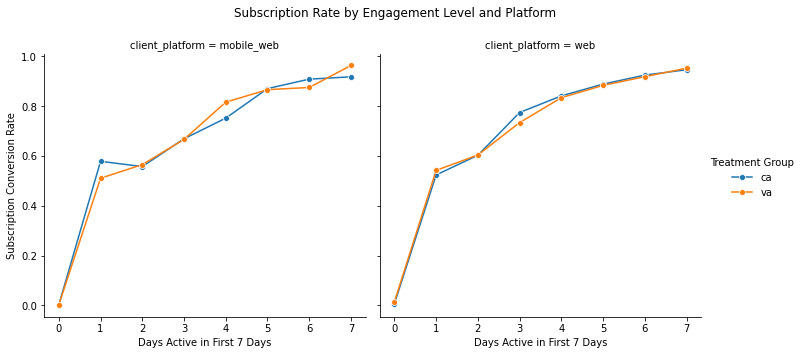

In [29]:
# facet plot of conversion by days in free trial
g = sns.FacetGrid(
    binned_conv_days,
    col="client_platform",
    hue="treatment",
    height=5,
    aspect=1
)
g.map(
    sns.lineplot,
    "count_days_active_in_first_7_days_of_trial",
    "sub_rate",
    marker="o"
)
g.add_legend(title="Treatment Group")
g.set_axis_labels("Days Active in First 7 Days", "Subscription Conversion Rate")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Subscription Rate by Engagement Level and Platform")
plt.show()

Test on Mobile Web has slightly lower proportion of customers in 1-2 days active, and then exceeds control at 4 and 7 days. Possibly noise. 

Test and Control on Web are near identical. 